In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

# Add parent directory to path.
from pathlib import Path
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
fdir = Path(os.path.abspath('')).resolve() # Directory of current file.
path = fdir/'..'
if path not in sys.path:
    sys.path.append(str(path))

# Complete imports.
from functools import partial
import makassar_ml as ml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import seaborn as sns
from sklearn.model_selection import ParameterGrid
sns.set() # Use seaborn themes.

# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    print(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


In [2]:
keras.backend.clear_session()

In [3]:
# Configure root paths.
config_roots = dict(
    hp_tuning_root=Path('~/research/makassar/hp_tuning').expanduser(),
)

In [4]:
epochs = 30
batch_size = 256

In [5]:
# Load the dataset.
dataset_kwargs = dict(
    image_shape=[72,72,3],
    split=['train[0%:70%]', 'train[70%:90%]', 'train[90%:]'],
    shuffle_files=False,
)
dataset_train, dataset_val, dataset_test = ml.datasets.plant_village.load_data(
    **dataset_kwargs,
    batch_size=batch_size,
)
n_batches = tf.data.experimental.cardinality(dataset_train)
n_steps = n_batches*epochs

In [6]:
print(f"{epochs=}")
print(f"{n_batches=}")
print(f"{n_steps=}")

epochs=30
n_batches=<tf.Tensor: shape=(), dtype=int64, numpy=149>
n_steps=<tf.Tensor: shape=(), dtype=int64, numpy=4470>


In [7]:
# Build and compile the model.
model = ml.models.ViT(
    image_shape=dataset_kwargs['image_shape'],
    n_class=38,
    patch_size=6,
    embed_dim=16,
    n_heads=8,
    ff_dim=256,
    dropout=0.1,
    n_encoders=3,
    fc_units=[],
)
# optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# optimizer = keras.optimizers.Adam(
#     keras.experimental.CosineDecayRestarts(
#         initial_learning_rate=1e-3,
#         first_decay_steps=1000,
#         )
# )
learning_rate = keras.experimental.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=n_steps,
    alpha=0.1,
)
# learning_rate = keras.experimental.CosineDecayRestarts(
#     initial_learning_rate=1e-3,
#     first_decay_steps=n_steps//3,
#     m_mul=0.8,
# )
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
metrics = ['accuracy']
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=metrics,
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72, 72, 3)]       0         
_________________________________________________________________
patches (Patches)            (None, 144, 108)          0         
_________________________________________________________________
patch_encoder (PatchEncoder) (None, 144, 16)           4048      
_________________________________________________________________
transformer_encoder_layer (T (None, 144, 16)           9616      
_________________________________________________________________
transformer_encoder_layer_1  (None, 144, 16)           9616      
_________________________________________________________________
transformer_encoder_layer_2  (None, 144, 16)           9616      
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0     

(<tf.Tensor: shape=(), dtype=float32, numpy=0.001>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.000100000114>)

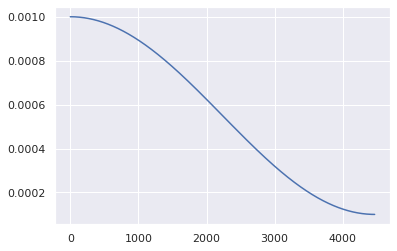

In [8]:
steps = np.arange(n_steps)
lrs = learning_rate(steps)
plt.plot(steps, lrs)
lrs[0],lrs[-1]

In [9]:
# Train.
# strategy = tf.distribute.get_strategy()
history = model.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=epochs,
    verbose=1,
)

Epoch 1/30
149/149 [==============================] - 21s 119ms/step - loss: 2.8189 - accuracy: 0.2708 - val_loss: 1.3224 - val_accuracy: 0.6139
Epoch 2/30
149/149 [==============================] - 14s 93ms/step - loss: 1.2322 - accuracy: 0.6368 - val_loss: 1.0250 - val_accuracy: 0.6899
Epoch 3/30
149/149 [==============================] - 14s 92ms/step - loss: 0.8731 - accuracy: 0.7373 - val_loss: 0.8634 - val_accuracy: 0.7354
Epoch 4/30
149/149 [==============================] - 14s 93ms/step - loss: 0.6932 - accuracy: 0.7898 - val_loss: 0.7183 - val_accuracy: 0.7799
Epoch 5/30
149/149 [==============================] - 14s 93ms/step - loss: 0.5561 - accuracy: 0.8294 - val_loss: 0.6429 - val_accuracy: 0.8015
Epoch 6/30
149/149 [==============================] - 14s 93ms/step - loss: 0.4513 - accuracy: 0.8643 - val_loss: 0.6009 - val_accuracy: 0.8155
Epoch 7/30
149/149 [==============================] - 14s 93ms/step - loss: 0.3763 - accuracy: 0.8867 - val_loss: 0.5613 - val_accuracy

/tmp/ipykernel_11087/2114538881.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


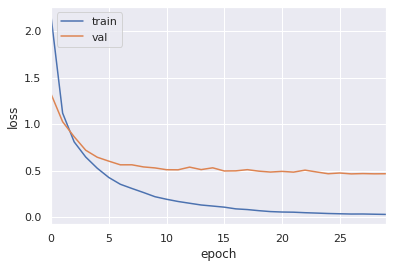

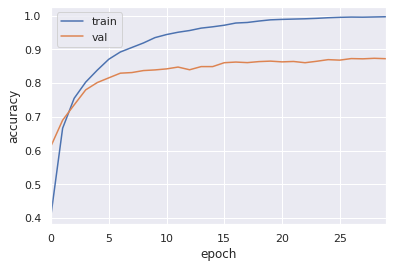

In [10]:
for key in ['loss']+metrics:
    fig = ml.visualization.plot_metric(history.history, key)
    fig.show()